In [4]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./Python', train = True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                      shuffle=True, num_workers = 2)
testset = torchvision.datasets.MNIST(root='./Python', train = False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                      shuffle=False, num_workers = 2)
classes = tuple(str(i) for i in range(10))

In [14]:
trainloader.dataset.train_data.shape

torch.Size([60000, 28, 28])

In [15]:
testloader.dataset.test_data.shape

torch.Size([10000, 28, 28])

In [16]:
trainloader.dataset.train_data[0]

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [17]:
numpy_img = trainloader.dataset.train_data[0].numpy()

In [19]:
numpy_img.shape

(28, 28)

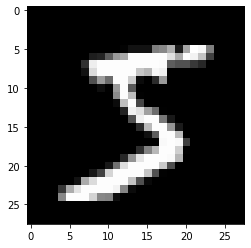

In [24]:
plt.imshow(numpy_img, cmap='gray');

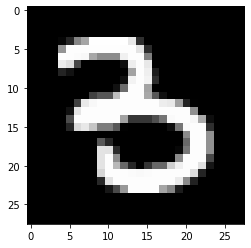

In [30]:
#вывод случайной цифры из датасета
i = np.random.randint(low=0, high=60000)
plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap='gray');

In [37]:
import torch.nn as nn
import torch.nn.functional as F

In [38]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [39]:
net = SimpleConvNet()

batch = []
batch = next(iter(trainloader))
net.forward(torch.FloatTensor(batch[0]))

tensor([[-0.0386, -0.0103, -0.0195, -0.0735, -0.0274,  0.0323, -0.0174, -0.0837,
         -0.0866, -0.0171],
        [-0.0373, -0.0083, -0.0195, -0.0749, -0.0328,  0.0337, -0.0183, -0.0889,
         -0.0855, -0.0178],
        [-0.0327, -0.0109, -0.0173, -0.0697, -0.0338,  0.0286, -0.0151, -0.0889,
         -0.0911, -0.0209],
        [-0.0325, -0.0124, -0.0192, -0.0736, -0.0364,  0.0350, -0.0189, -0.0815,
         -0.0880, -0.0174]], grad_fn=<AddmmBackward0>)

In [41]:
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [44]:
from tqdm import tqdm_notebook

In [51]:
net = SimpleConvNet().to(device)

In [55]:
loss_fn = torch.nn.CrossEntropyLoss() #функция потерь
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
losses = []

C:\Users\User\AppData\Local\Temp/ipykernel_25092/344496430.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(2)):


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp/ipykernel_25092/344496430.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.170
[1,  4000] loss: 0.153
[1,  6000] loss: 0.143
[1,  8000] loss: 0.131
[1, 10000] loss: 0.120
[1, 12000] loss: 0.111
[1, 14000] loss: 0.097


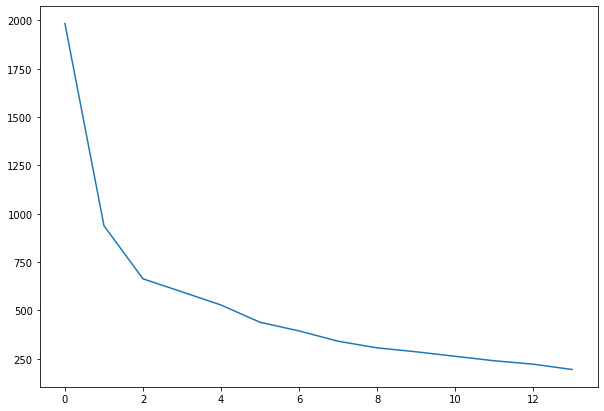

Обучение закончено


C:\Users\User\AppData\Local\Temp/ipykernel_25092/344496430.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.101
[2,  4000] loss: 0.096
[2,  6000] loss: 0.086
[2,  8000] loss: 0.081
[2, 10000] loss: 0.091
[2, 12000] loss: 0.083
[2, 14000] loss: 0.081
Обучение закончено


In [58]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)

for epoch in tqdm_notebook(range(2)):
    running_loss = 0.0
    for i,batch in enumerate(tqdm_notebook(trainloader)):
        X_batch, y_batch = batch
        optimizer.zero_grad() #обнуляем веса
        #forward + backward + optimize
        y_pred = net(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()
        #вывод текущего loss
        running_loss += loss.item()
        #вывод качества каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            losses.append(running_loss)
            running_loss = 0.0
        
    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

    print('Обучение закончено')

In [59]:
#Тестируем на тестовых данных использую метрицу accuracy_score
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        
        c = predicted.cpu().detach() == labels
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 98 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 97 %
Accuracy of     4 : 97 %
Accuracy of     5 : 96 %
Accuracy of     6 : 98 %
Accuracy of     7 : 97 %
Accuracy of     8 : 96 %
Accuracy of     9 : 97 %


# Новый датасет из цветных картинок

In [61]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./Python', train = True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                      shuffle=True, num_workers = 2)
testset = torchvision.datasets.CIFAR10(root='./Python', train = False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                      shuffle=False, num_workers = 2)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./Python\cifar-10-python.tar.gz to ./Python
Files already downloaded and verified


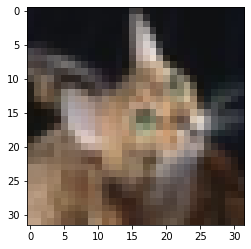

In [65]:
i = np.random.randint(low=0, high=50000)
plt.imshow(trainloader.dataset.data[i]);

In [66]:
next(iter(trainloader))[0].shape

torch.Size([128, 3, 32, 32])

In [71]:
class MyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(6 * 6 * 128, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 6 * 6 * 128) #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [72]:
net = MyConvNet().to(device)

loss_fn = torch.nn.CrossEntropyLoss() #функция потерь
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

for epoch in tqdm_notebook(range(10)):
    running_loss = 0.0
    
    for i,batch in enumerate(tqdm_notebook(trainloader)):
        X_batch, y_batch = batch
        optimizer.zero_grad() #обнуляем веса
        #forward + backward + optimize
        y_pred = net(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()
        #вывод текущего loss
        running_loss += loss.item()
        #вывод качества каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
    print('Обучение закончено')

C:\Users\User\AppData\Local\Temp/ipykernel_25092/3995808945.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp/ipykernel_25092/3995808945.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,batch in enumerate(tqdm_notebook(trainloader)):


  0%|          | 0/391 [00:00<?, ?it/s]

Обучение закончено


  0%|          | 0/391 [00:00<?, ?it/s]

Обучение закончено


  0%|          | 0/391 [00:00<?, ?it/s]

Обучение закончено


  0%|          | 0/391 [00:00<?, ?it/s]

Обучение закончено


  0%|          | 0/391 [00:00<?, ?it/s]

Обучение закончено


  0%|          | 0/391 [00:00<?, ?it/s]

Обучение закончено


  0%|          | 0/391 [00:00<?, ?it/s]

Обучение закончено


  0%|          | 0/391 [00:00<?, ?it/s]

Обучение закончено


  0%|          | 0/391 [00:00<?, ?it/s]

Обучение закончено


  0%|          | 0/391 [00:00<?, ?it/s]

Обучение закончено


In [73]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        
        c = predicted.cpu().detach() == labels.squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 48 %
Accuracy of   car : 75 %
Accuracy of  bird : 36 %
Accuracy of   cat : 52 %
Accuracy of  deer : 37 %
Accuracy of   dog : 30 %
Accuracy of  frog : 66 %
Accuracy of horse : 60 %
Accuracy of  ship : 87 %
Accuracy of truck : 61 %
